In [1]:
# main 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# viz
import matplotlib.pyplot as plt
%matplotlib inline

# deal with warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set path
path = '/kaggle/input/playground-series-s4e5'

# load data
train = pd.read_csv(f'{path}/train.csv', index_col=0)
test = pd.read_csv(f'{path}/test.csv', index_col=0)

# Features

In [3]:
def stat_features(data, only_stat=False):
    """
    A lot of statistic features
    """
    df = data.copy()
    cols = df.columns
    
    df['fsum'] = df[cols].sum(axis=1)
    df['special1'] = df['fsum'].isin(np.arange(72, 76))

    df['fstd'] = df[cols].std(axis=1)
    df['fmedian'] = df[cols].median(axis=1)
    df['min_all'] = df[cols].min(axis=1)
    df['max_all'] = df[cols].max(axis=1)
    df['ptp'] = df[cols].values.ptp(axis=1)
    df['q25'] = df[cols].quantile(0.25, axis=1)
    df['q75'] = df[cols].quantile(0.75, axis=1)
    df['fskew'] = df[cols].skew(axis=1)
    df['fkurtosis'] = df[cols].kurtosis(axis=1)
    
    if only_stat:
        df = df.drop(columns=cols)
        
    return df


In [4]:
train.head(3)

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530


In [5]:
test.head(3)

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
id,,,,,,,,,,,,,,,,,,,,
1117957,4,6,3,5,6,7,8,7,8,4,8,5,7,5,6,3,6,4,4,5
1117958,4,4,2,9,5,5,4,7,5,4,2,4,7,4,5,1,7,4,4,3
1117959,1,3,6,5,7,2,4,6,4,2,7,9,2,5,5,2,3,6,8,3


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train_full = train.drop(columns = ['FloodProbability'])
y_train_full = train[['FloodProbability']].copy()

X_train_full = stat_features(data=X_train_full)
X_test = stat_features(data=test)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, 
                                                  y_train_full, 
                                                  test_size=0.2,
                                                  random_state=42)

# # StratifiedShuffleSplit
# splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
# train_idx, val_idx = next(splitter.split(X_train_full, y_train_full))

# X_train, y_train = X_train_full.iloc[train_idx], y_train_full.iloc[train_idx]
# X_val, y_val = X_train_full.iloc[val_idx], y_train_full.iloc[val_idx]


print(f'train_shape {X_train.shape},\n val_shape {X_val.shape}')

train_shape (894365, 31),
 val_shape (223592, 31)


# Building mlp model

In [8]:
import tensorflow as tf
import keras_tuner as kt
tf.keras.backend.clear_session()

2024-05-21 10:56:27.500661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 10:56:27.500769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 10:56:27.632121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# !pip install tensorboard

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9377729477947985633
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16274030592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1392840546882993541
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


## BaseLine MLP model
building model using sequantial API

In [13]:
# tf.random.set_seed(42)

# norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
# model = tf.keras.models.Sequential([
#     norm_layer,
#     tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
#     tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
#     tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
#     tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
#     tf.keras.layers.Dense(1)
# ])

# model.summary()

In [14]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# model.compile(loss='mse', 
#               optimizer=optimizer, 
#               metrics=[tf.keras.metrics.R2Score])
# norm_layer.adapt(X_train.values)

# history = model.fit(X_train, 
#                     y_train,
#                     epochs=3, 
#                     validation_data=(X_val, y_val))

# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
# model.compile(loss='mse', 
#               optimizer=optimizer, 
#               metrics=[tf.keras.metrics.R2Score])
# norm_layer.adapt(X_train.values)

# history = model.fit(X_train, 
#                     y_train,
#                     batch_size=256,
#                     epochs=3, 
#                     validation_data=(X_val, y_val))

## Main model

In [15]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=128)
    batch_size = hp.Choice('batch', [32, 64, 128])
    activation = hp.Choice('activation', ['relu', 'sigmoid'])
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="log")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model = tf.keras.Sequential()
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.R2Score])
    return model

class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)
    
    def fit(self, hp, model, X, y, **kwargs):
        norm_layer = tf.keras.layers.Normalization()
        X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [16]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), 
    objective='val_r2_score',
    seed=42,
    max_trials=20, 
    alpha=1e-4, 
    beta=2.6,
    overwrite=True, 
    directory="s4e5", 
    project_name="bayesian_opt"
)

In [18]:
from pathlib import Path
root_logdir = Path(bayesian_opt_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3)
bayesian_opt_tuner.search(
    X_train, y_train, epochs=10, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_cb, tensorboard_cb]
)

Trial 2 Complete [00h 07m 37s]

Best val_accuracy So Far: None
Total elapsed time: 00h 18m 31s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
8                 |6                 |n_hidden
85                |20                |n_neurons
128               |64                |batch
relu              |relu              |activation
0.00085475        |0.00059777        |learning_rate

Epoch 1/10
27949/27949 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - loss: 0.0012 - r2_score: 0.5667 - val_loss: 4.3385e-04 - val_r2_score: 0.8331
Epoch 2/10
27949/27949 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 4.3217e-04 - r2_score: 0.8342 - val_loss: 4.4445e-04 - val_r2_score: 0.8291
Epoch 3/10
27949/27949 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 4.2229e-04 - r2_score: 0.8382 - val_loss: 4.1114e-04 - val_r2_score: 0.8419
Epoch 4/10
27949/27949 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 4.1896e-04 - r2_score: 0.8389 - val_loss: 4.6873e-04 - val_r2_score: 0.8197
Epoch 5/10
27949/27949 ━

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 264, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File "/opt/conda/lib/python3.10/site-packages/kera

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 264, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 116, in _get_best_value_and_best_epoch_from_history
    objective_value = objective.get_value(metrics)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/objective.py", line 59, in get_value
    return logs[self.name]
KeyError: 'val_accuracy'


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

In [97]:
y_pred = model.predict(X_test.values)

23291/23291 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step


<Axes: ylabel='Count'>

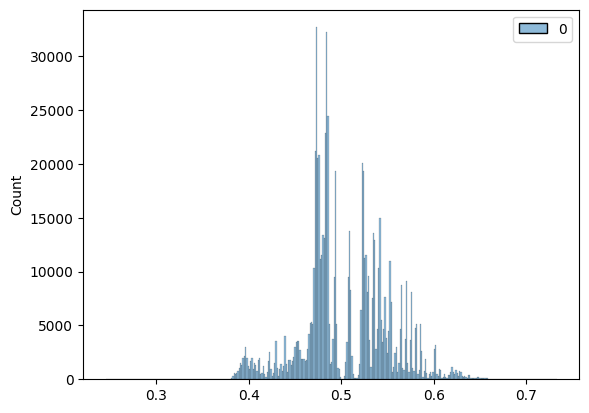

In [98]:
import seaborn as sns
sns.histplot(y_pred)

In [ ]:
sub = pd.DataFrame({'FloodProbability': y_pred.reshape(-1)},
             index=test.index)
sub.to_csv('submission.csv', index=True)
